<span style='font-family: Times; font-size: 2em;'>MIMIC v. 2.2 Database Dynamic Exploratory Data Analysis</span>


**Veronica Ramirez-Lopera** 

### Objectives: 
#### Main objective:
To assess whether the MIMIC-IV database contains sufficient sequential ECGs to support a study 
on the dynamic aging of the heart in heart failure patients.

#### Secondary objectives:
1. To analyze the timing of ECGs during each hospitalization.
1. To visualize patient distribution by ECG frequency and hospitalization count.
1. To describe a plan for the research protocol modifications according to the ECG data.

### **Table of contents**
- [Introduction](#introduction)
- [Package Requirements](#package_requirements)
- [Data importing](#importing)
- [Data filtering and visualization](#filtering)
- [Conclusions and plan](#conclusions)
- [References](#references)

## Introduction <a name='introduction'></a>
MIMIC-IV is a freely available electronic health record (EHR) dataset encompassing a decade of patient information (2008-2019) from Beth Israel Deaconess Medical Center [1]. It surpasses its predecessor, MIMIC-III, with a better structure and additional patient information [2, 3].

The dataset draws upon two primary sources: a comprehensive hospital-wide EHR system and an ICU-specific clinical information system [1]. Rigorous de-identification procedures ensure patient privacy while preserving the data's scientific integrity.

It includes vital signs, diagnoses, medications, procedures, and de-identified clinical notes [1]. Researchers leverage MIMIC-IV to investigate disease progression, train machine learning models, and develop clinical decision support tools [1, 2].

As a result, null dates of death indicate the patient was alive at least up to that time point. Inferences regarding patient death beyond one year cannot be made using MIMIC-IV (as per the PhyioNet website) [2]. The majority of patient death information is acquired from hospital records when the individual dies within the BIDMC or an affiliated institute.

MIMIC-IV also offers a dedicated module: MIMIC-IV ECG. This subset focuses specifically on diagnostic electrocardiograms (ECGs) [2]. It includes approximately 800,000 10-second ECG recordings from nearly 160,000 unique patients. Each ECG utilizes 12 leads and is sampled at 500 Hz [3].


## Package requirements <a name='package_requirements'></a>

Notes: 

1- You need to install gcloud if you haven't already. Alternatively, you can use the provided csv files that contain the data.


In [2]:

from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import missingno as msno
from scipy.stats import shapiro


# Formatting for my pandas dataframes, ignore:

pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None) 

# Construct a BigQuery client
client = bigquery.Client()

# Data Importing <a name='importing'></a>
By using SQL, I will import the required data into the local environment and organize it in a pandas dataset. For the purpose of this analysis, I will need:

- subject_id: Unique identifier for each patient, used to link admissions and ECG records.- hadm_id: Identifier for each hospitalization event, allowing differentiation between multiple admissions for the same patient.
- admittime/dischtime: Admission and discharge timestamps to determine the hospitalization period and align ECG events within the correct timeframe.
- admission_type: Type of admission (e.g., emergency, elective) to categorize hospitalizations and assess their impact on ECG frequency.
- admission_location: The location or source of admission (e.g., ER, clinic).
- study_id: Unique identifier for each ECG study, used to track individual ECG events.
- file_name: Name of the ECG file, useful for accessing raw waveform data if needed for deeper analysis.
- ecg_time: Timestamp of when the ECG was performed, helps with determining its relation to the admission period.
- path: File path to the ECG data, allowing retrieval of the raw ECG waveform files for further analysis if required.

In [2]:
# Data importing 

# Fetch admissions data
'''
With the following code i will fetch both the ecg paths AND the admissions table, but only if the 
ecg was in the context of an admission this is to ensure that the ecgs were not taken during the
same visit, and at two different times in the patients life, which can showcase the dynamic 
changes in the heart that ocur during hospitalizations. 

'''

admissions_query = '''
SELECT 
  a.subject_id,
  a.hadm_id,
  a.admittime,
  a.dischtime,
  a.admission_type,
  a.admission_location,
  a. race,
  b.gender,
  b.anchor_year_group,
  b. anchor_year,
  b. anchor_age,
  b.dod,
  e.study_id,
  e.file_name,
  e.ecg_time,
  e.path
FROM 
  `physionet-data.mimiciv_hosp.admissions` AS a
INNER JOIN
  `physionet-data.mimiciv_hosp.patients` AS b
ON 
  a.subject_id = b.subject_id
LEFT JOIN 
  `physionet-data.mimiciv_ecg.record_list` AS e
ON 
  a.subject_id = e.subject_id
  AND e.ecg_time BETWEEN a.admittime AND a.dischtime                     
'''


# Fetch the admissions data as a DataFrame
admissions = client.query(admissions_query).to_dataframe(create_bqstorage_client=True)

# Save the admissions data to a CSV file

path = r'C:\Users\Vero Ramirez\Desktop\CODE\CODE\admissions.csv'
admissions.to_csv(path, index=False)

print('\nAdmissions data:')
print(admissions.head())

c:\Users\Vero Ramirez\AppData\Local\Programs\Python\Python312\Lib\site-packages\google\cloud\bigquery\table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [3]:
# Load the admissions data from the CSV file, 

'''
Since running the query is time-consuming, I will save the data to a CSV file and load it from there. 
This approach will also help avoid additional costs and allow for more efficient work.
'''
path = r'C:\Users\Vero Ramirez\Desktop\CODE\CODE\admissions.csv'
admissions = pd.read_csv(path)


# General Visualization of the dataset

- Drop the missing Values
- visualize the demographic data 

Axes(0.125,0.11;0.698618x0.77)


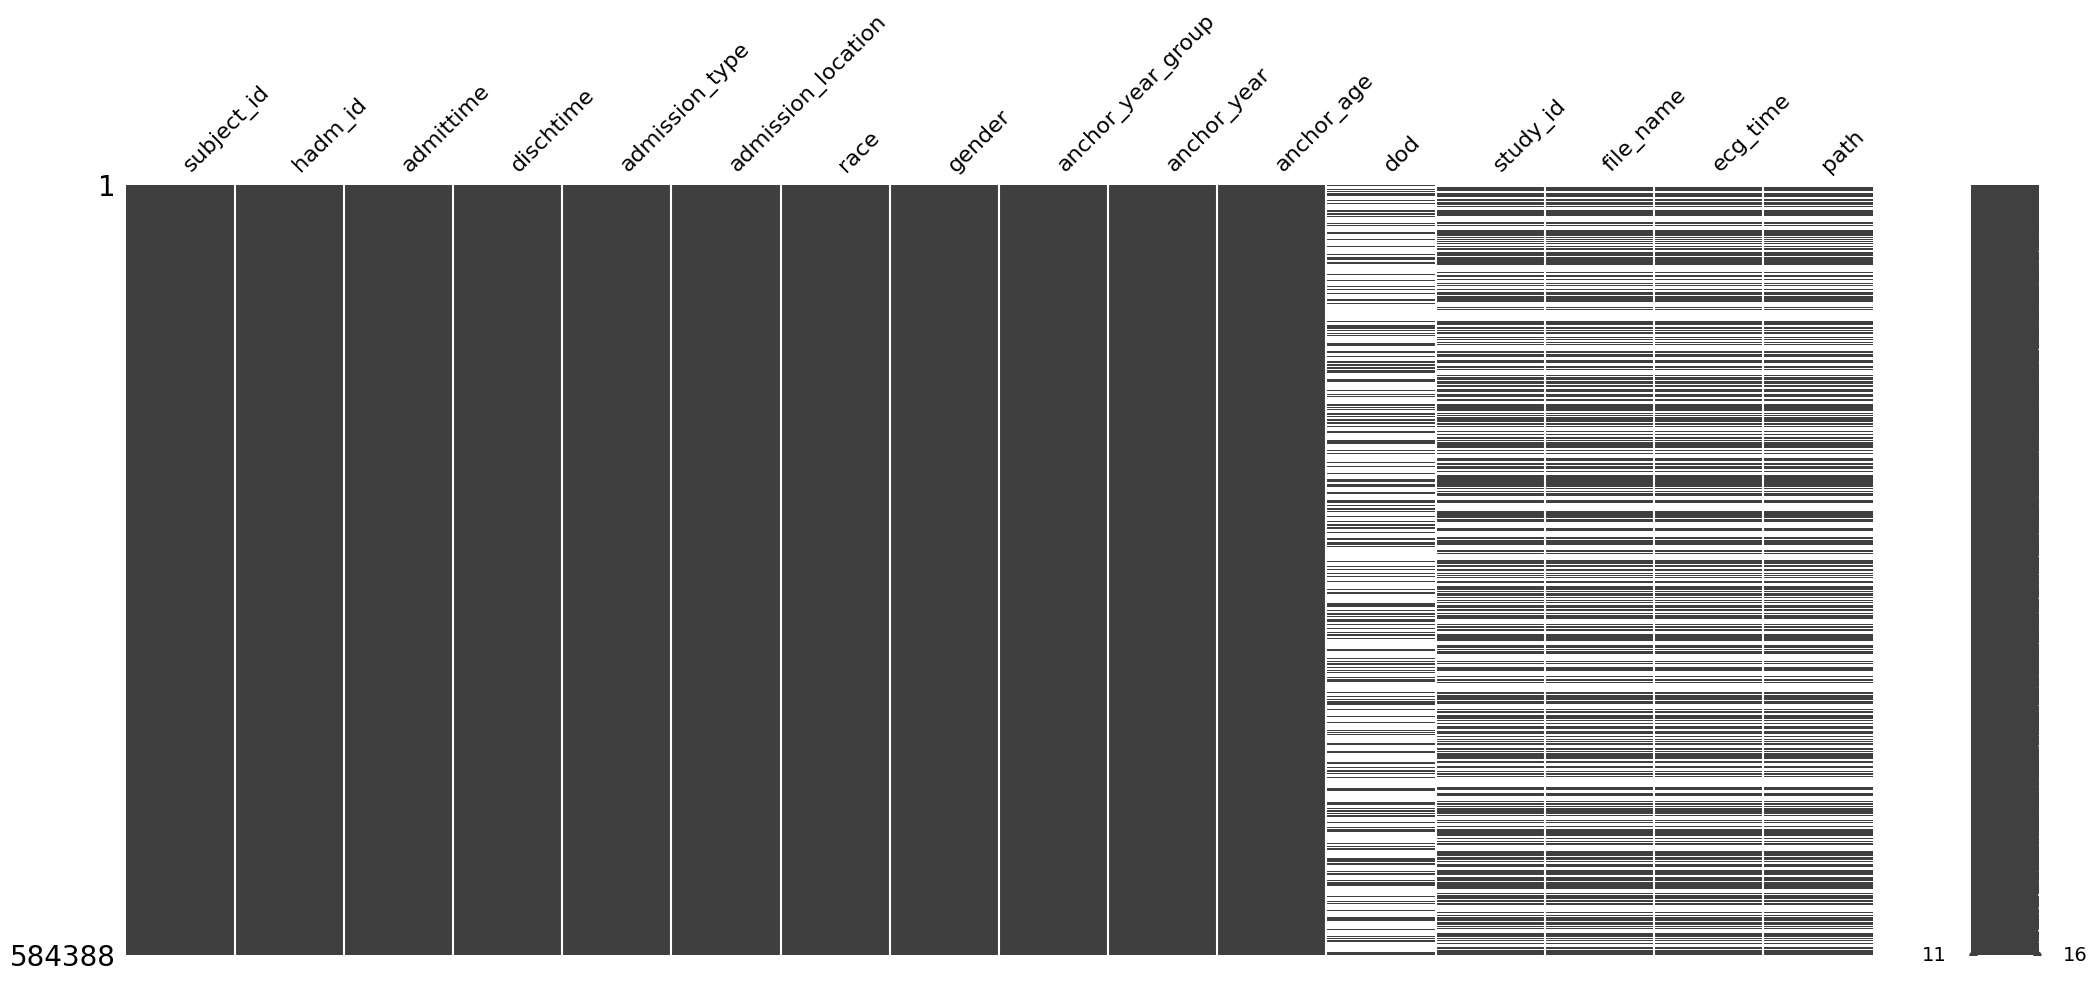

In [4]:
# Lets visualize the missing values in the admissions data
print(msno.matrix(admissions))


There are missing values in the dod category, which is to be expected due to the fact that most of the population was still alive up to three years after their admission. 


The missing values in the rest of the categories mean that not every admission had an ECG associated.

# Understanding the data
Lets visualize the data and add the length of stay

In [5]:
#Organize the data so we can start the analysis

# 1.Convert the 'admittime' and 'dischtime' columns to datetime objects
admissions['admittime'] = pd.to_datetime(admissions['admittime'])
admissions['dischtime'] = pd.to_datetime(admissions['dischtime'])
admissions['length_of_stay_(days)'] = admissions['dischtime'] - admissions['admittime']             # Calculate the length of stay an add it as a new column
admissions['length_of_stay_(days)'] = admissions['length_of_stay_(days)'].dt.days                   # Convert the length of stay to days
print(admissions['length_of_stay_(days)'].describe())

# 2. Create a separate table that only contains the unique patients in subject_id
''' 
The reason for this is that we want to have a unique patient per row, and not have the same patient
appear multiple times in the data for the demographic analysis.
'''
patients = admissions[admissions.duplicated(subset='subject_id') == False]                          # Filter out the repeated patients
print(patients.head())

# 3. Create a new column 'age' that calculates the age of the patient at the time of admission
''' 
This is done by substracting the anchor_year_group from the anchor_age to calculate the birth year, 
and then substracting the birth year from the admission year to get the age.

 age = hospital admission time - anchor_year + anchor_age
'''
patients['age'] = patients['admittime'].dt.year - patients['anchor_year'] + patients['anchor_age']

print(patients.head())

count    584388.000000
mean          6.659261
std          12.206168
min          -1.000000
25%           1.000000
50%           3.000000
75%           7.000000
max         295.000000
Name: length_of_stay_(days), dtype: float64
   subject_id   hadm_id           admittime           dischtime  \
0    10106244  26713233 2147-05-09 10:34:00 2147-05-12 13:43:00   
4    13700703  20448599 2172-09-25 01:01:00 2172-10-03 13:25:00   
5    15443666  27961368 2168-12-30 23:30:00 2169-01-05 16:02:00   
6    16299919  26977065 2193-05-15 08:37:00 2193-05-17 16:03:00   
7    19596808  26675460 2128-06-04 16:13:00 2128-06-05 11:36:00   

      admission_type  admission_location                    race gender  \
0       DIRECT EMER.  PHYSICIAN REFERRAL                   WHITE      F   
4  OBSERVATION ADMIT      EMERGENCY ROOM                   WHITE      F   
5  OBSERVATION ADMIT      EMERGENCY ROOM  BLACK/AFRICAN AMERICAN      F   
6  OBSERVATION ADMIT      EMERGENCY ROOM  BLACK/AFRICAN AMERICAN     

C:\Users\Vero Ramirez\AppData\Local\Temp\ipykernel_35128\2586320800.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  patients['age'] = patients['admittime'].dt.year - patients['anchor_year'] + patients['anchor_age']


In [6]:
# Count the number of deceased and unique patients 
unique_count = admissions['subject_id'].nunique()
dead_counts = patients['dod'].apply(lambda x: 'dead' if pd.notna(x) else 'alive')
dead_counts_summary = dead_counts.value_counts()

print(f'There are {unique_count} unique patients in the admissions data, and:')
print(f'{dead_counts_summary.get("dead", 0)} are dead.')
print(f'{dead_counts_summary.get("alive", 0)} are alive.')



There are 180733 unique patients in the admissions data, and:
27980 are dead.
152753 are alive.


In [7]:
# Shapiro test for normality of the age feature

from scipy.stats import shapiro
stat, p = shapiro(patients['age'])
print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret the test
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian ')
else:
    print('Sample does not look Gaussian ')
    
patients['age'].median()
    
    

Statistics=0.968, p=0.000
Sample does not look Gaussian 


c:\Users\Vero Ramirez\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 180733.
  res = hypotest_fun_out(*samples, **kwds)


58.0

C:\Users\Vero Ramirez\AppData\Local\Temp\ipykernel_35128\1069517694.py:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(patients['age'], bins=30, kde=True, ax=axes[0], palette='pastel')


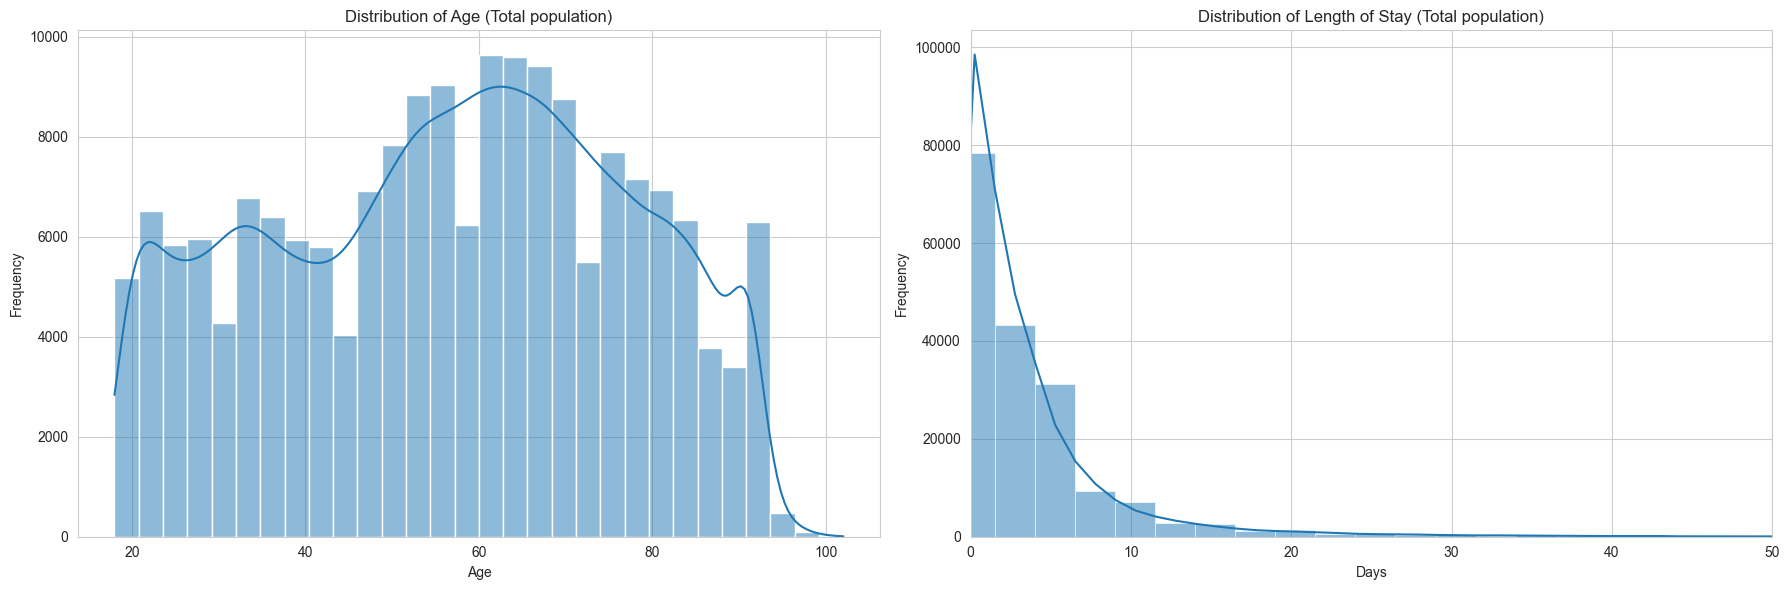

In [8]:
# Lets visualize the demographic data (patients that have at least one admission)
'''
Having at least one admission is a requirement to later visualize the diagnosis data.
'''

# Set the style of the plots
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot the distribution of the anchor_age variable
sns.histplot(patients['age'], bins=30, kde=True, ax=axes[0], palette='pastel')
axes[0].set_title('Distribution of Age (Total population)')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Frequency')

# Plot the distribution of the length_of_stay variable 
'''  
The length of stay is the number of days a patient stays in the hospital.
'''
sns.histplot(patients['length_of_stay_(days)'], bins=100, kde=True, ax=axes[1])
axes[1].set_title('Distribution of Length of Stay (Total population)')
axes[1].set_xlabel('Days')
axes[1].set_ylabel('Frequency')
axes[1].set_xlim(0, 50)
# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()


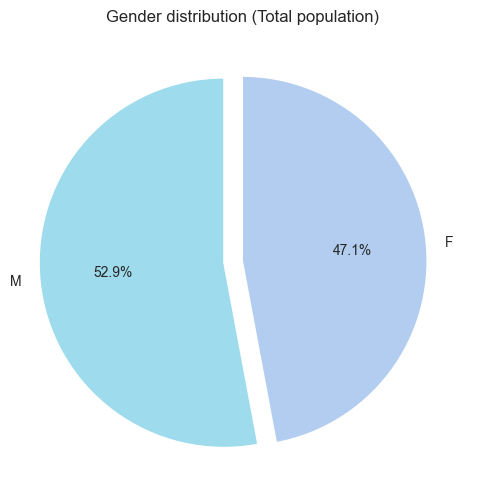

In [49]:
# Now lets do this for the gender

#do a pie chart 

plt.figure(figsize=(6, 6))
patients['gender'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, explode=(0.1, 0), \
    shadow=False, colors=['#9edbec', '#b2cdef'])
plt.title('Gender distribution (Total population)')
plt.ylabel('')
plt.show()


C:\Users\Vero Ramirez\AppData\Local\Temp\ipykernel_9956\171999476.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data =common_race, ax=axes[0], palette='viridis')
C:\Users\Vero Ramirez\AppData\Local\Temp\ipykernel_9956\171999476.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), ha='right')
C:\Users\Vero Ramirez\AppData\Local\Temp\ipykernel_9956\171999476.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=dead_counts, ax=axes[1], palette='viridis')


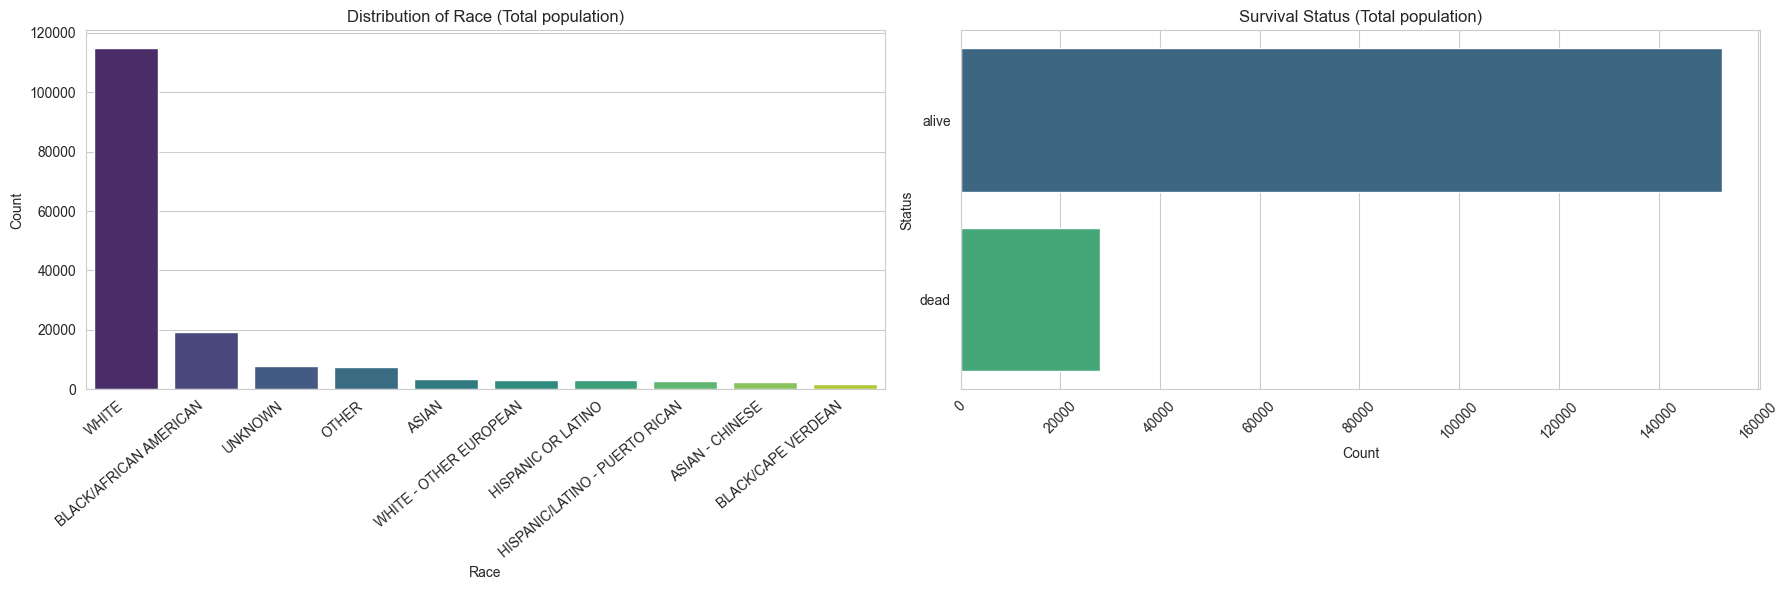

In [79]:
# Lets graph a barplot for race and dod

fig, axes = plt.subplots(1, 2, figsize=(18, 6) )

# Plot the distribution of the 'race' variable (only the 10 most common), and exclude missing values
common_race = patients['race'].value_counts().head(10).dropna()

sns.barplot(data =common_race, ax=axes[0], palette='viridis')
axes[0].set_title('Distribution of Race (Total population)')
axes[0].set_xlabel('Race')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=40)
axes[0].set_xticklabels(axes[0].get_xticklabels(), ha='right')

# Plot the distribution of 'dod'
sns.countplot(data=dead_counts, ax=axes[1], palette='viridis')
axes[1].set_title('Survival Status (Total population)')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Status')
axes[1].tick_params(axis='x', rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()


# Data filtering and visualization <a name='filtering'></a>

At this point, we have a dataset containing all patients who were hospitalized at least once, regardless of their diagnosis. Our goal now is to determine the number of hospitalizations for each patient and the number of ECGs recorded during each hospitalization.

In [12]:
# First, lets drop any hospitalization that does not have an ecg 
'''
We will drop any hospitalization that does not have an ECG, as the purpose of this report is to 
analyze whether there is enough data to analyze the dynamic changes in the heart during 
hospitalizations, and to create a model that can predict the outcome of a patient based on their
ECG data. 

'''

admissions = admissions.dropna(subset=['path'])                                                      # Drop rows with missing ECG paths
patients = patients.dropna(subset=['path'])     

In [13]:

# Lets count the amount of unique patients with at least one ECG and how many are dead or alive
unique_count = admissions['subject_id'].nunique()
dead_counts = patients['dod'].apply(lambda x: 'dead' if pd.notna(x) else 'alive')
dead_counts_summary = dead_counts.value_counts()

print(f'There are {unique_count} unique patients in the admissions data, that have an ECG and:')
print(f'{dead_counts_summary.get("dead", 0)} are dead.')
print(f'{dead_counts_summary.get("alive", 0)} are alive.')



There are 82213 unique patients in the admissions data, that have an ECG and:
13413 are dead.
45571 are alive.


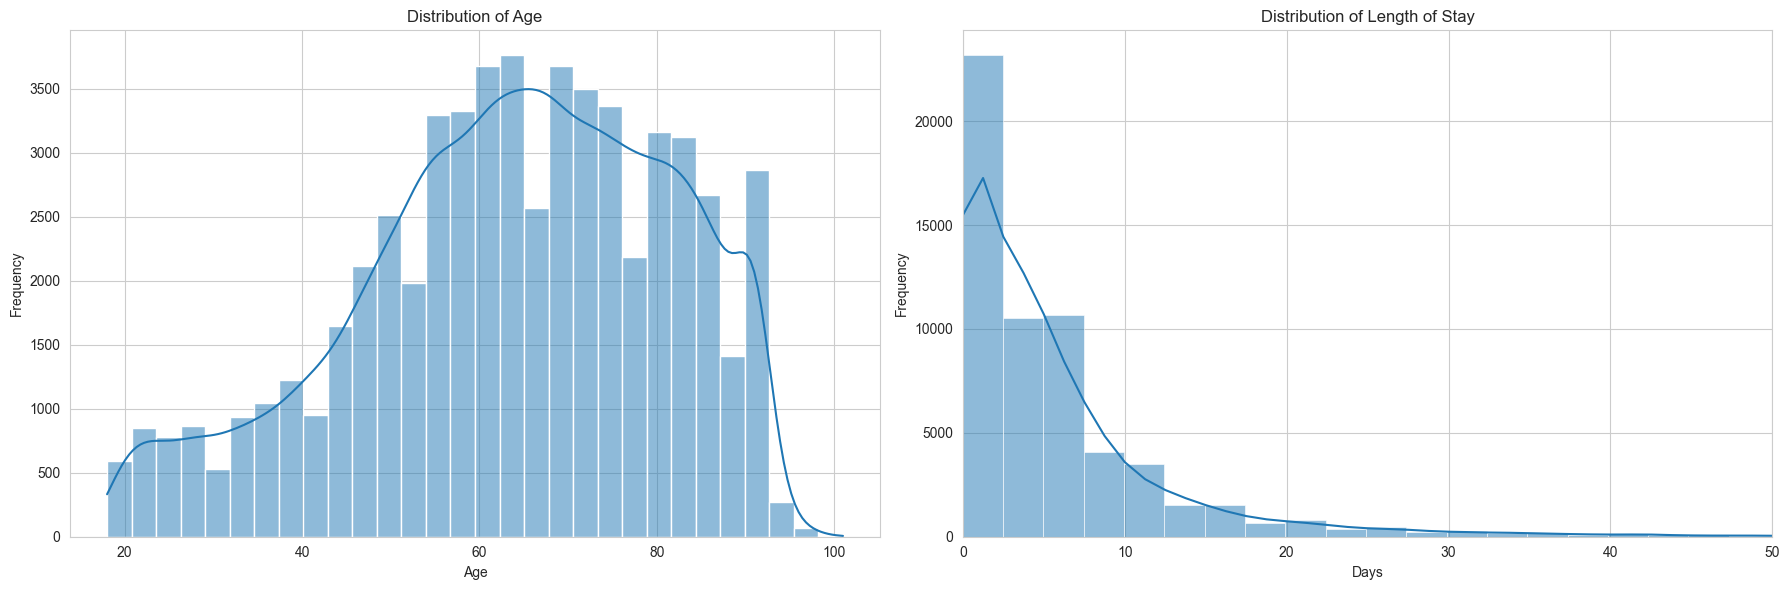

In [34]:
# Lets visualize the demographic data (patients that have at least one admission)
'''
Having at least one admission is a requirement to later visualize the diagnosis data.
'''

# Set the style of the plots
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot the distribution of the anchor_age variable
sns.histplot(patients['age'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Distribution of Age (All the patients with ECGs)')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Frequency')

# Plot the distribution of the length_of_stay variable 
'''  
The length of stay is the number of days a patient stays in the hospital.
'''
sns.histplot(patients['length_of_stay_(days)'], bins=100, kde=True, ax=axes[1])
axes[1].set_title('Distribution of Length of Stay (All the patients with ECGs)')
axes[1].set_xlabel('Days')
axes[1].set_ylabel('Frequency')
axes[1].set_xlim(0, 50)
# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()


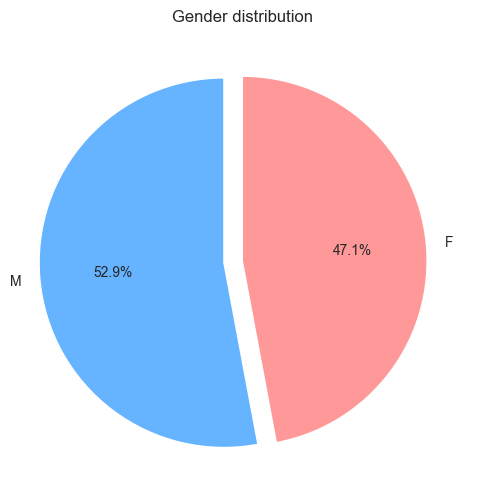

In [47]:
# Now lets plot the gender distribution

plt.figure(figsize=(6, 6))
patients['gender'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, explode=(0.1, 0), \
shadow=False, colors = ['#66b3ff', '#ff9999'])
plt.title('Gender distribution')
plt.ylabel('')
plt.show()

C:\Users\Vero Ramirez\AppData\Local\Temp\ipykernel_9956\3010368775.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data =common_race, ax=axes[0], palette='pastel')
C:\Users\Vero Ramirez\AppData\Local\Temp\ipykernel_9956\3010368775.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=dead_counts, ax=axes[1], palette='pastel')


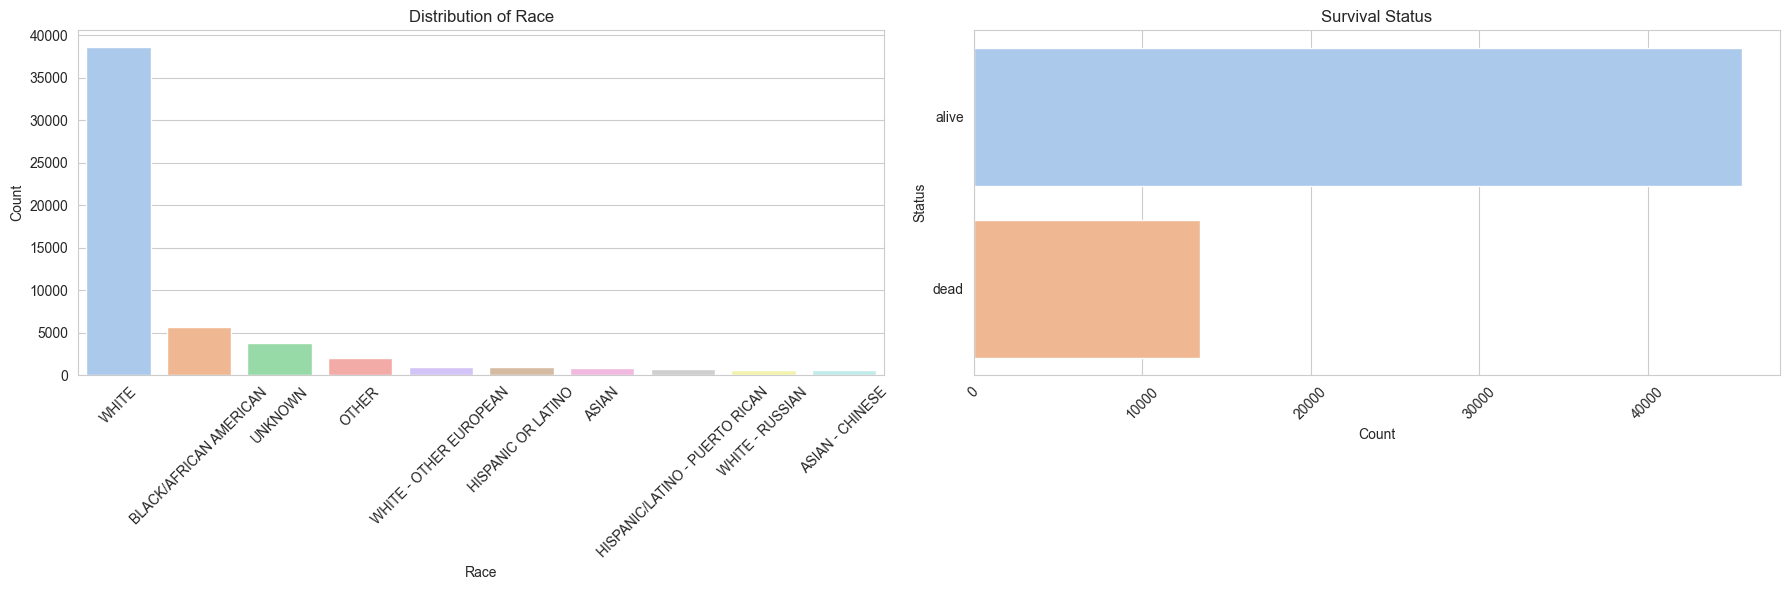

In [16]:
# Lets graph a barplot for race and dod

fig, axes = plt.subplots(1, 2, figsize=(18, 6) )

# Plot the distribution of the 'race' variable (only the 10 most common)
common_race = patients['race'].value_counts().head(10)

sns.barplot(data =common_race, ax=axes[0], palette='pastel')
axes[0].set_title('Distribution of Race')
axes[0].set_xlabel('Race')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

# Plot the distribution of 'dod'
sns.countplot(data=dead_counts, ax=axes[1], palette='pastel')
axes[1].set_title('Survival Status')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Status')
axes[1].tick_params(axis='x', rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

Now, lets see how many patients had a heart failure diagnosis 

In [17]:
# Lets create a dataframe with the icd_codes and the icd guide
'''
We will fetch the ICD guide and the ICD data from the hosp module 
'''
icd_query_guide = '''
SELECT
icd_code,
icd_version,
long_title
FROM
    `physionet-data.mimiciv_hosp.d_icd_diagnoses`
'''

icd_query = '''
SELECT 
subject_id,
hadm_id,
icd_code,
icd_version,
seq_num
FROM
    `physionet-data.mimiciv_hosp.diagnoses_icd`

'''
#Fetch the data as a DataFrame
icd_guide = client.query(icd_query_guide).to_dataframe(create_bqstorage_client=True)
icd = client.query(icd_query).to_dataframe(create_bqstorage_client=True)

# Display the first few rows of the DataFrames
print('\nICD guide data:')
print(icd_guide.head())

print('\nICD data:')
print(icd.head())

KeyboardInterrupt: 

In [36]:
# Lets merge the icd data with the icd guide data
'''
This will allow us to decipher the icd codes and see the different diagnosis for the patients with
more than one admission
'''
icd_merged = pd.merge(icd, icd_guide, on=['icd_code', 'icd_version'], how='inner')

# Save the merged ICD data to a CSV file so we can load it later without running the query again
path = r'C:\Users\Vero Ramirez\Desktop\CODE\CODE\icd_merged.csv'
icd_merged.to_csv(path, index=False)

NameError: name 'icd' is not defined

In [80]:
# Load the merged ICD data from the CSV file
path = r'C:\Users\Vero Ramirez\Desktop\CODE\CODE\icd_merged.csv'
icd_merged = pd.read_csv(path)

In [81]:
# Lets drop the patients that did not have a heart failure diagnosis
'''  
This will help us visualize the population we will be working with
'''
# First we have to merge the admissions and icd data 

admissions_icd = pd.merge( admissions, icd_merged, on=['hadm_id'], how= 'left')

heart_failure_icd9 = [
    '428', '4280', '4281', '4282', '42820', '42821', '42822', '42823', 
    '4283', '42830', '42831', '42832', '42833', '4284', '42840', '42841', 
    '42842', '42843', '4289', '40201', '40211', '40291', '40401', 
    '40403', '40411', '40413', '40491', '40493']

heart_failure_icd10 = [
    'I50', 'I501', 'I502', 'I5020', 'I5021', 'I5022', 'I5023', 
    'I503', 'I5030', 'I5031', 'I5032', 'I5033', 'I504', 'I5040', 
    'I5041', 'I5042', 'I5043', 'I508', 'I5081', 'I50810', 'I50811', 
    'I50812', 'I50813', 'I50814', 'I5082', 'I5083', 'I5084', 'I5089', 
    'I509']

heart_failure_codes = heart_failure_icd9 + heart_failure_icd10
heart_failure_admissions = admissions_icd[admissions_icd['icd_code'].isin(heart_failure_codes)] 

# Lets visualize the data
heart_failure_admissions.head() 


,subject_id_x,hadm_id,admittime,dischtime,admission_type,admission_location,race,gender,anchor_year_group,anchor_year,anchor_age,dod,study_id,file_name,ecg_time,path,length_of_stay_(days),subject_id_y,icd_code,icd_version,seq_num,long_title
6,10106244,26713233,2147-05-09 10:34:00,2147-05-12 13:43:00,DIRECT EMER.,PHYSICIAN REFERRAL,WHITE,F,2011 - 2013,2144,60,NaN,49164244.0,49164244.0,2147-05-09 11:06:00,files/p1010/p10106244/s49164244/49164244,3,10106244.0,I501,10.0,3.0,"Left ventricular failure, unspecified"
31,10106244,26713233,2147-05-09 10:34:00,2147-05-12 13:43:00,DIRECT EMER.,PHYSICIAN REFERRAL,WHITE,F,2011 - 2013,2144,60,NaN,44859244.0,44859244.0,2147-05-09 16:53:00,files/p1010/p10106244/s44859244/44859244,3,10106244.0,I501,10.0,3.0,"Left ventricular failure, unspecified"
56,10106244,26713233,2147-05-09 10:34:00,2147-05-12 13:43:00,DIRECT EMER.,PHYSICIAN REFERRAL,WHITE,F,2011 - 2013,2144,60,NaN,40600970.0,40600970.0,2147-05-10 08:17:00,files/p1010/p10106244/s40600970/40600970,3,10106244.0,I501,10.0,3.0,"Left ventricular failure, unspecified"
81,10106244,26713233,2147-05-09 10:34:00,2147-05-12 13:43:00,DIRECT EMER.,PHYSICIAN REFERRAL,WHITE,F,2011 - 2013,2144,60,NaN,48644999.0,48644999.0,2147-05-11 07:27:00,files/p1010/p10106244/s48644999/48644999,3,10106244.0,I501,10.0,3.0,"Left ventricular failure, unspecified"
108,15443666,27961368,2168-12-30 23:30:00,2169-01-05 16:02:00,OBSERVATION ADMIT,EMERGENCY ROOM,BLACK/AFRICAN AMERICAN,F,2014 - 2016,2167,75,NaN,NaN,NaN,NaN,NaN,5,15443666.0,I509,10.0,3.0,"Heart failure, unspecified"


In [82]:
#Lets repeat the same procedure with the HF patients

HF_patients = heart_failure_admissions[heart_failure_admissions.\
    duplicated(subset='subject_id_x') == False]                                                     # Filter out the repeated patients
print(HF_patients.head())

#Calculate the age
HF_patients['age'] = HF_patients['admittime'].dt.year - HF_patients['anchor_year'] + HF_patients[
    'anchor_age']

     subject_id_x   hadm_id           admittime           dischtime  \
6        10106244  26713233 2147-05-09 10:34:00 2147-05-12 13:43:00   
108      15443666  27961368 2168-12-30 23:30:00 2169-01-05 16:02:00   
160      15868868  27142491 2191-08-07 13:06:00 2191-08-11 19:55:00   
357      10433099  28593361 2148-12-24 20:41:00 2149-02-01 14:30:00   
677      12862321  27343985 2190-09-25 13:53:00 2190-10-15 14:48:00   

        admission_type     admission_location                    race gender  \
6         DIRECT EMER.     PHYSICIAN REFERRAL                   WHITE      F   
108  OBSERVATION ADMIT         EMERGENCY ROOM  BLACK/AFRICAN AMERICAN      F   
160             URGENT  WALK-IN/SELF REFERRAL                   WHITE      M   
357           EW EMER.         EMERGENCY ROOM  BLACK/AFRICAN AMERICAN      M   
677           EW EMER.         EMERGENCY ROOM                   ASIAN      F   

    anchor_year_group  anchor_year  anchor_age         dod    study_id  \
6         2011 - 2

C:\Users\Vero Ramirez\AppData\Local\Temp\ipykernel_9956\2187700740.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HF_patients['age'] = HF_patients['admittime'].dt.year - HF_patients['anchor_year'] + HF_patients[


In [83]:
# Lets count the amount of unique patients with at least one ECG and how many are dead or alive
unique_count = heart_failure_admissions['subject_id_x'].nunique()
dead_counts = HF_patients['dod'].apply(lambda x: 'dead' if pd.notna(x) else 'alive')
dead_counts_summary = dead_counts.value_counts()

print(f'There are {unique_count} unique patients in the admissions data, that have an ECG and:')
print(f'{dead_counts_summary.get("dead", 0)} are dead.')
print(f'{dead_counts_summary.get("alive", 0)} are alive.')


There are 24032 unique patients in the admissions data, that have an ECG and:
9979 are dead.
14053 are alive.


There are 24032 unique patients in the admissions data, that have a HF diagnosis    and at least one ECG per admission
9979 are dead.
14053 are alive.


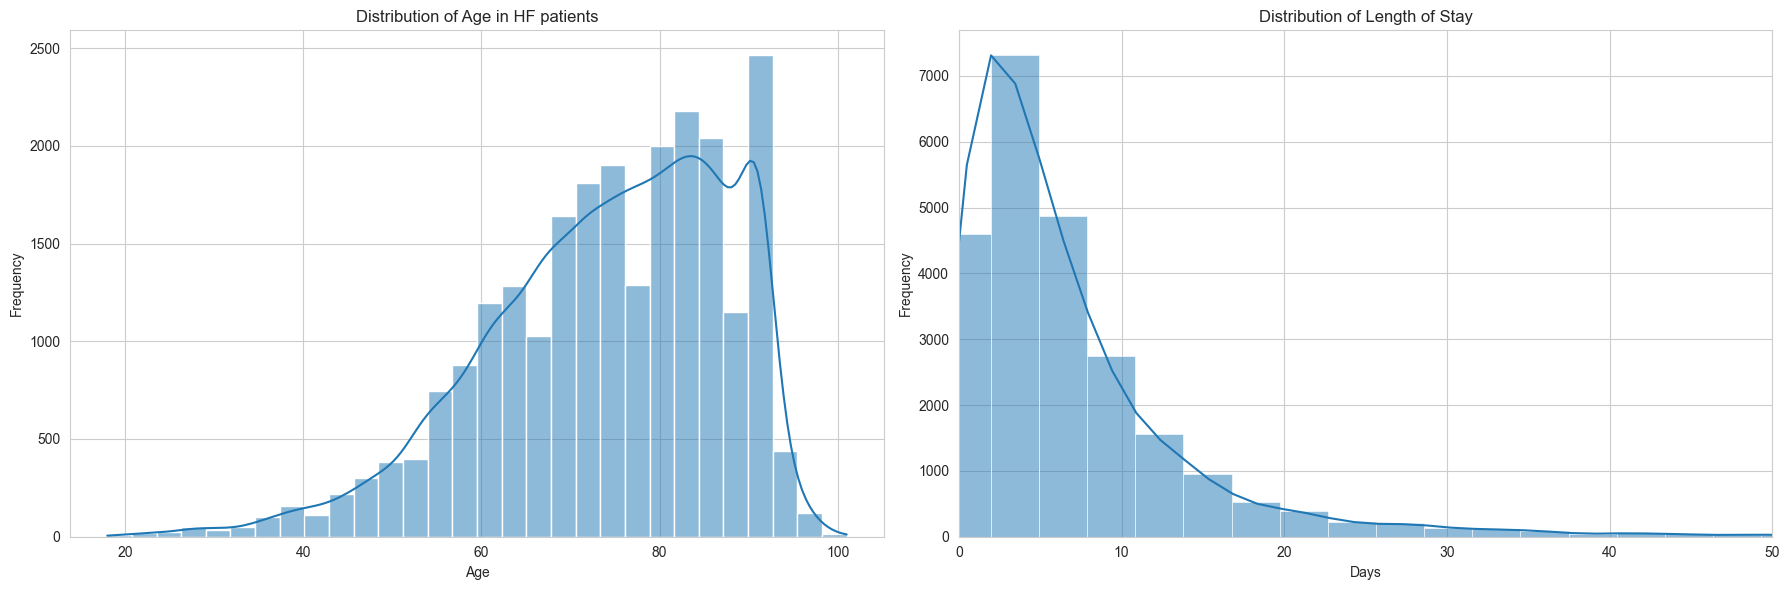

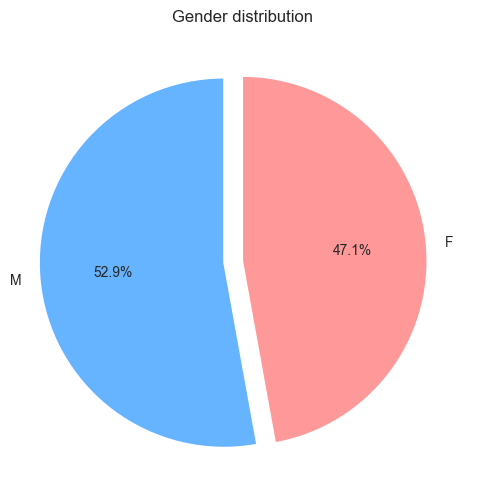

C:\Users\Vero Ramirez\AppData\Local\Temp\ipykernel_9956\4101822980.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data =common_race, ax=axes[0], palette='pastel')
C:\Users\Vero Ramirez\AppData\Local\Temp\ipykernel_9956\4101822980.py:63: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), ha='right')
C:\Users\Vero Ramirez\AppData\Local\Temp\ipykernel_9956\4101822980.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=dead_counts, ax=axes[1], palette='pastel')


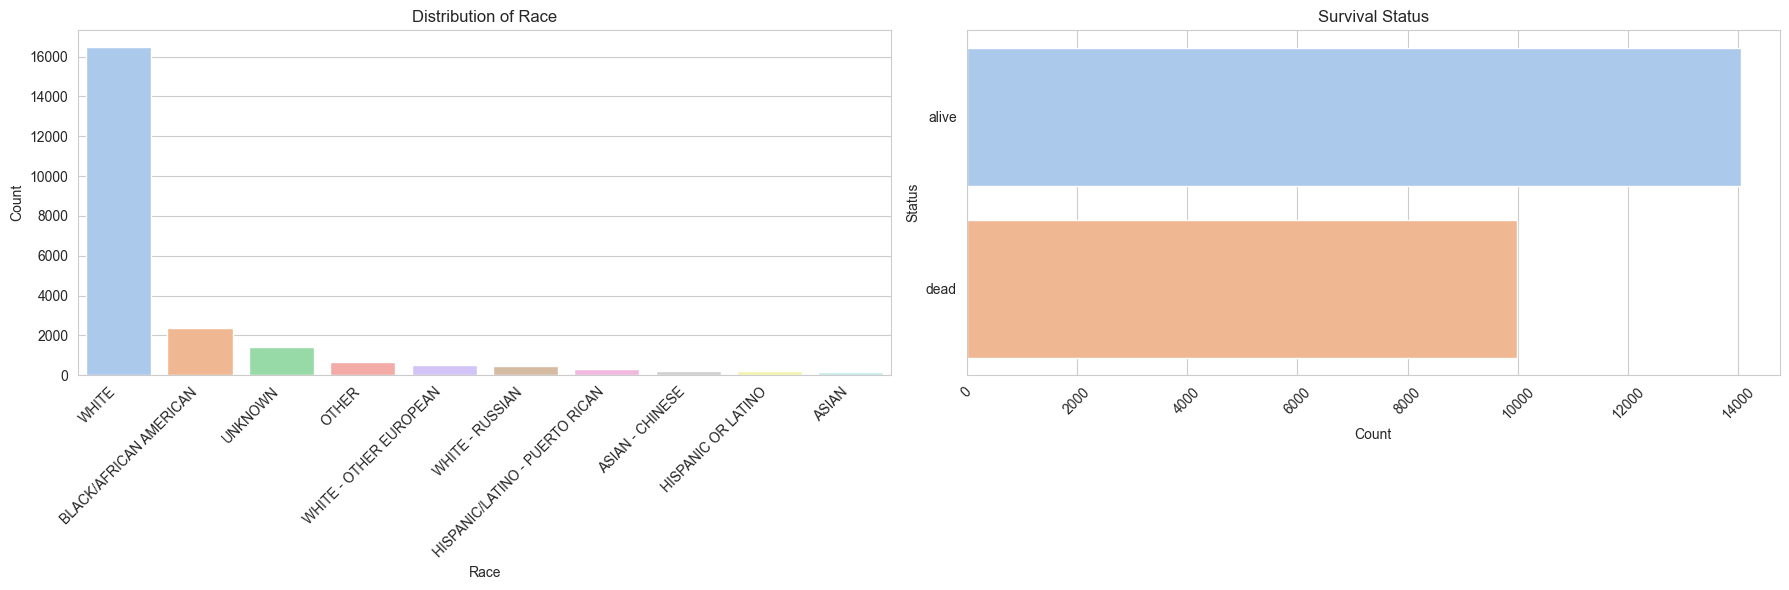

In [85]:


# Lets count the amount of unique patients with at least one ECG and how many are dead or alive
unique_count = heart_failure_admissions['subject_id_x'].nunique()
dead_counts = HF_patients['dod'].apply(lambda x: 'dead' if pd.notna(x) else 'alive')
dead_counts_summary = dead_counts.value_counts()

print(f'There are {unique_count} unique patients in the admissions data, that have a HF diagnosis\
    and at least one ECG per admission')
print(f'{dead_counts_summary.get("dead", 0)} are dead.')
print(f'{dead_counts_summary.get("alive", 0)} are alive.')


# Lets visualize the demographic data (patients that have at least one admission)
'''
Having at least one admission is a requirement to later visualize the diagnosis data.
'''

# Set the style of the plots
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot the distribution of the anchor_age variable
sns.histplot(HF_patients['age'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Distribution of Age in HF patients')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Frequency')

# Plot the distribution of the length_of_stay variable 
'''  
The length of stay is the number of days a patient stays in the hospital.
'''
sns.histplot(HF_patients['length_of_stay_(days)'], bins=100, kde=True, ax=axes[1])
axes[1].set_title('Distribution of Length of Stay')
axes[1].set_xlabel('Days')
axes[1].set_ylabel('Frequency')
axes[1].set_xlim(0, 50)
# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

# Now lets plot the gender distribution

plt.figure(figsize=(6, 6))
HF_patients['gender'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, explode=(0.1, 0), \
shadow=False, colors=['#66b3ff', '#ff9999'])
plt.title('Gender distribution')
plt.ylabel('')
plt.show()

# Lets graph a barplot for race and dod

fig, axes = plt.subplots(1, 2, figsize=(18, 6) )

# Plot the distribution of the 'race' variable (only the 10 most common)
common_race = HF_patients['race'].value_counts().head(10).dropna()

sns.barplot(data =common_race, ax=axes[0], palette='pastel')
axes[0].set_title('Distribution of Race')
axes[0].set_xlabel('Race')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_xticklabels(axes[0].get_xticklabels(), ha='right')

# Plot the distribution of 'dod'
sns.countplot(data=dead_counts, ax=axes[1], palette='pastel')
axes[1].set_title('Survival Status')
axes[1].set_xlabel('Count')
axes[1].set_ylabel('Status')
axes[1].tick_params(axis='x', rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

In [40]:
# Shapiro test for normality of the age feature in the heart failure population


stat, p = shapiro(HF_patients['age'])
print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret the test
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian ')
else:
    print('Sample does not look Gaussian ')
    
HF_patients['age'].median()

Statistics=0.957, p=0.000
Sample does not look Gaussian 


c:\Users\Vero Ramirez\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 17898.
  res = hypotest_fun_out(*samples, **kwds)


76.0

In [50]:
# Lets drop the patients that only had one admission (the combination of subject_id and hadm_id \
# is unique)

admission_counts = admissions.groupby('subject_id')['hadm_id'].nunique()                            # Count the number of admissions per patient
admission_counts = admission_counts[admission_counts > 1]                                           # Filter patients with more than one admission 
admissions = admissions[admissions['subject_id'].isin(admission_counts.index)]                      # Filter the admissions dataframe to include only patients with more 
                                                                                                    # than one admission
admission_counts = admission_counts.reset_index()
admission_counts.columns = ['subject_id', 'Unique admissions']                                      # Rename the columns of admission_counts

print(admission_counts.head())
print(admissions.head())

   subject_id  Unique admissions
0    10000935                  3
1    10000980                  5
2    10001401                  2
3    10001877                  2
4    10001884                 12
   subject_id   hadm_id           admittime           dischtime  \
0    10106244  26713233 2147-05-09 10:34:00 2147-05-12 13:43:00   
1    10106244  26713233 2147-05-09 10:34:00 2147-05-12 13:43:00   
2    10106244  26713233 2147-05-09 10:34:00 2147-05-12 13:43:00   
3    10106244  26713233 2147-05-09 10:34:00 2147-05-12 13:43:00   
4    13700703  20448599 2172-09-25 01:01:00 2172-10-03 13:25:00   

      admission_type  admission_location   race gender anchor_year_group  \
0       DIRECT EMER.  PHYSICIAN REFERRAL  WHITE      F       2011 - 2013   
1       DIRECT EMER.  PHYSICIAN REFERRAL  WHITE      F       2011 - 2013   
2       DIRECT EMER.  PHYSICIAN REFERRAL  WHITE      F       2011 - 2013   
3       DIRECT EMER.  PHYSICIAN REFERRAL  WHITE      F       2011 - 2013   
4  OBSERVATION ADMI

In [51]:
# Lets see how many unique patients we have left

unique_patients = admissions['subject_id'].nunique()

print( f'After dropping the patients that only had one hospitalization, there are \
{unique_patients} unique patients in the dataset with more than one admission, that have at least \
one ECG during their hospitalization.')

After dropping the patients that only had one hospitalization, there are 26769 unique patients in the dataset with more than one admission, that have at least one ECG during their hospitalization.


In [9]:
# Lets summarize how many patients have more than one admission and how many admissions they have
'''
It is important to see the distribution of patients by the number of admissions they have, as this
will allow us to plan ahead what to do with our research

'''
admission_counts = admissions.groupby('subject_id')['hadm_id'].nunique()
patients_per_admission = admission_counts.value_counts().sort_index()                               # Count the number of patients with a given number of admissions
patients_per_admission = patients_per_admission.reset_index()                                       # Reset the index of the DataFrame     
patients_per_admission.columns = ['Number of admissions per patient', 
                                  'Number of patients']                                             # Rename the columns for readability

# Display the results
print(patients_per_admission.head())
print(admission_counts.describe())                                                                  # Summary statistics for the number of admissions


   Number of admissions per patient  Number of patients
0                                 1              101198
1                                 2               35712
2                                 3               15923
3                                 4                8738
4                                 5                5205
count    180733.000000
mean          2.386011
std           3.467248
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         238.000000
Name: hadm_id, dtype: float64


C:\Users\Vero Ramirez\AppData\Local\Temp\ipykernel_35128\3708787825.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Number of admissions per patient', y='Percentage of patients',


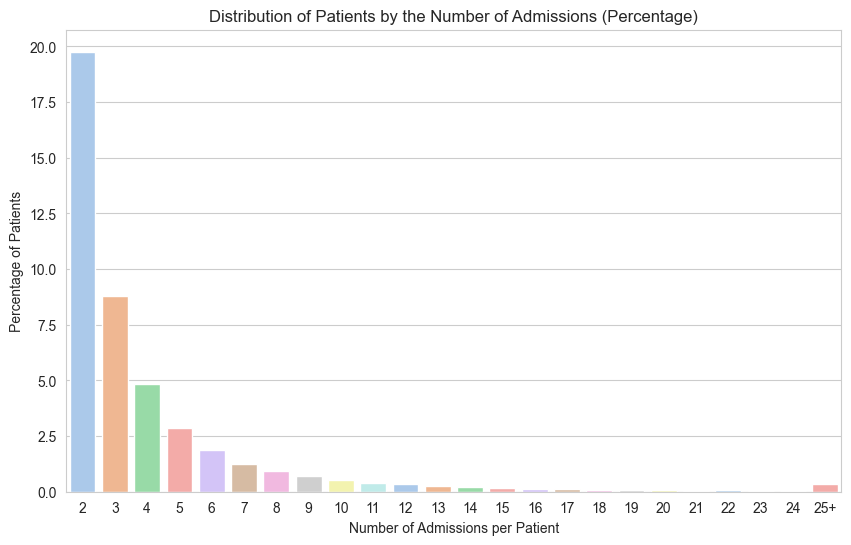

In [10]:
# Lets plot the distribution of patients by the number of admissions 
'''
There are multiple single patients that have more than 25 unique stays,
Lets combine categories with more than 24 admissions to simplify the visualization.
'''
patients_per_admission['Number of admissions per patient'] = patients_per_admission['Number of admissions per patient'].apply(
        lambda x: '25+' if x > 24 else str(x))
patients_per_admission = \
        patients_per_admission.groupby('Number of admissions per patient').sum().reset_index()       # Group by the new 'Number of admissions per patient' to sum up the patients 

# Calculate the percentage of patients for each category
total_patients = patients_per_admission['Number of patients'].sum()                                 # Calculate the total number of patients
patients_per_admission['Percentage of patients'] = \
    (patients_per_admission['Number of patients'] / total_patients) * 100
patients_per_admission['Number of admissions per patient'] = pd.Categorical(                        # Convert the 'Number of admissions per patient' column to a categorical type
    patients_per_admission['Number of admissions per patient'],
    categories=[str(i) for i in range(2, 25)] + ['25+'],
    ordered=True)

# Plot the distribution 
plt.figure(figsize=(10, 6))
sns.barplot(x='Number of admissions per patient', y='Percentage of patients', 
            data=patients_per_admission, palette = 'pastel')
plt.title('Distribution of Patients by the Number of Admissions (Percentage)')                      # Set the title and labels
plt.ylabel('Percentage of Patients')
plt.xlabel('Number of Admissions per Patient')
plt.show()

The data shows that most patients have two admissions, with the highest number of admissions per individual reaching 60. On average, each patient has 3.3 admissions with associated ECGs, and the standard deviation is 2.7. To better reflect the aging process, I am interested in analyzing only the first and last available ECGs. Therefore, we will filter out all intermediate ECGs.

In [57]:
# Lets analyze the timing of ECGs during each hospitalization
'''
We will keep the first ECG for the first hospitalization and the last ECG for the last 
hospitalization of each patient, as this will allow us to analyze the dynamic changes in the heart
'''
admissions['ecg_time'] = pd.to_datetime(admissions['ecg_time'])                                     # Convert the 'ecg_time' column to datetime
admissions = admissions.sort_values(by=['subject_id', 'ecg_time'])
first_and_last_ecgs = admissions.groupby('subject_id').agg({'ecg_time': ['first', 'last']})
first_and_last_ecgs.columns = ['first_ecg_time', 'last_ecg_time']                                    # Rename the columns for readability
first_and_last_ecgs = first_and_last_ecgs.reset_index()
print(first_and_last_ecgs)


       subject_id      first_ecg_time       last_ecg_time
0        10000935 2187-07-11 21:51:00 2187-10-10 20:39:00
1        10000980 2188-01-03 19:56:00 2193-08-15 16:41:00
2        10001401 2131-10-01 12:39:00 2131-11-14 03:16:00
3        10001877 2149-05-25 02:44:00 2150-11-21 23:10:00
4        10001884 2125-10-27 09:17:00 2131-01-13 08:25:00
...           ...                 ...                 ...
26764    19998497 2139-07-02 07:53:00 2145-07-30 19:21:00
26765    19998562 2166-03-16 19:13:00 2166-04-16 10:27:00
26766    19998770 2179-04-27 08:37:00 2182-08-20 12:43:00
26767    19999287 2191-12-30 03:53:00 2197-08-05 02:06:00
26768    19999840 2164-07-27 08:37:00 2164-09-17 11:31:00

[26769 rows x 3 columns]


In [58]:
# Lets calculate the time between the first and last ECG for each patient
'''
We will calculate the time between the first and last ECG for each patient, as this will allow us to
set a time frame for our analysis
'''

# Calculate the time difference in time between the first and last ECGs
first_and_last_ecgs['time_difference'] = \
(first_and_last_ecgs['last_ecg_time'] - first_and_last_ecgs['first_ecg_time']).\
    dt.total_seconds() / 3600

# Convert the time difference to months
first_and_last_ecgs['time_difference'] = first_and_last_ecgs['time_difference'] / (24*30)
print(first_and_last_ecgs.head(), first_and_last_ecgs['time_difference'].describe())                # Summary statistics for the time difference


   subject_id      first_ecg_time       last_ecg_time  time_difference
0    10000935 2187-07-11 21:51:00 2187-10-10 20:39:00         3.031667
1    10000980 2188-01-03 19:56:00 2193-08-15 16:41:00        68.362153
2    10001401 2131-10-01 12:39:00 2131-11-14 03:16:00         1.453634
3    10001877 2149-05-25 02:44:00 2150-11-21 23:10:00        18.195046
4    10001884 2125-10-27 09:17:00 2131-01-13 08:25:00        63.465463 count    26769.000000
mean        30.151750
std         31.673684
min          0.000000
25%          3.854606
50%         18.186042
75%         48.539190
max        132.387731
Name: time_difference, dtype: float64


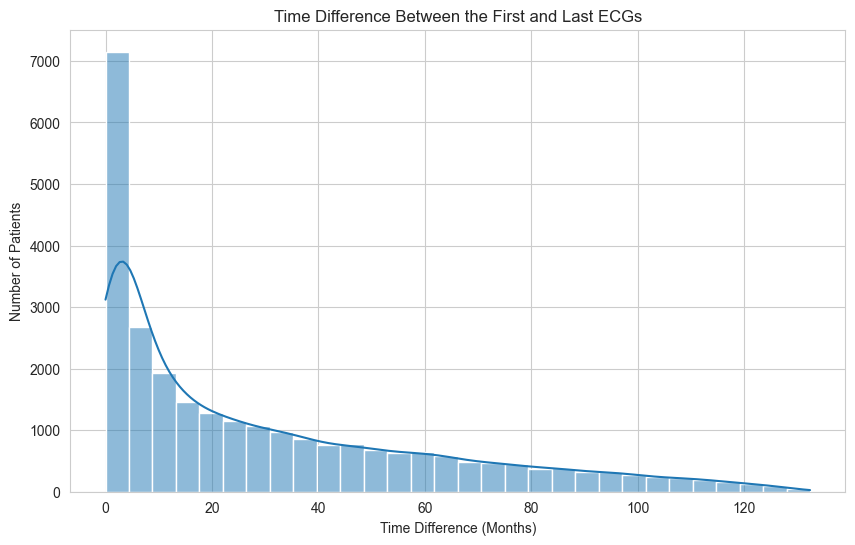

In [59]:
# Lets plot the distribution of the time difference between the first and last ECGs

plt.figure(figsize=(10, 6))
sns.histplot(first_and_last_ecgs['time_difference'], bins=30, kde=True)
plt.title('Time Difference Between the First and Last ECGs')                                        # Set the title and labels
plt.xlabel('Time Difference (Months)')
plt.ylabel('Number of Patients')
plt.show()

The average time between the first and last ECGs is 30 months, with a standard deviation of 31 months. The minimum time is 0 months, and the maximum is 132 months, equivalent to 11 years.

With multiple patients having ECGs recorded across more than one hospitalization, we are well-positioned to analyze dynamic changes in the heart over time. Our next step is to examine the heart failure diagnoses to determine if we have sufficient information to develop a profile for these patients.

In [ ]:
# Load the merged ICD data from the CSV file
path = r'C:\Users\Vero Ramirez\Desktop\CODE\CODE\icd_merged.csv'
icd_merged = pd.read_csv(path)

In [60]:
# Lets filter the icd data to only include heart failure diagnosis

'''
We will filter the icd data to only include heart failure diagnosis. The codes for heart failure
were taken from Yang et al. (2019) [4]
'''
heart_failure_icd9 = [
    '428', '4280', '4281', '4282', '42820', '42821', '42822', '42823', 
    '4283', '42830', '42831', '42832', '42833', '4284', '42840', '42841', 
    '42842', '42843', '4289', '40201', '40211', '40291', '40401', 
    '40403', '40411', '40413', '40491', '40493']

heart_failure_icd10 = [
    'I50', 'I501', 'I502', 'I5020', 'I5021', 'I5022', 'I5023', 
    'I503', 'I5030', 'I5031', 'I5032', 'I5033', 'I504', 'I5040', 
    'I5041', 'I5042', 'I5043', 'I508', 'I5081', 'I50810', 'I50811', 
    'I50812', 'I50813', 'I50814', 'I5082', 'I5083', 'I5084', 'I5089', 
    'I509']

heart_failure_codes = heart_failure_icd9 + heart_failure_icd10
heart_failure_data = icd_merged[icd_merged['icd_code'].isin(heart_failure_codes)]                   # Filter the ICD data to include only heart failure diagnoses

heart_failure_data                                                                                  # Display the filtered data

,subject_id,hadm_id,icd_code,icd_version,seq_num,long_title
144,10253057,20746562,4280,9,31,"Congestive heart failure, unspecified"
202,10361825,27526421,4280,9,33,"Congestive heart failure, unspecified"
585,10996711,29843687,4280,9,27,"Congestive heart failure, unspecified"
827,11343484,29736871,4280,9,32,"Congestive heart failure, unspecified"
980,11666315,29093415,4280,9,28,"Congestive heart failure, unspecified"
...,...,...,...,...,...,...
4754637,19900168,20669156,4280,9,25,"Congestive heart failure, unspecified"
4754856,11284817,23075349,I509,10,25,"Heart failure, unspecified"
4754970,11885720,27266103,I5030,10,25,Unspecified diastolic (congestive) heart failure
4755056,12315453,24388774,I509,10,25,"Heart failure, unspecified"


In [61]:
# Lets merge the heart failure data with the admissions data

'''
We will only include the patients that have a heart failure diagnosis in the admissions data of 
patients,but just for the first and last hospitalization corresponding to the first and last ECGs 
of each patient.
'''

#First, lets drop any hospitalization that is not the first or last hospitalization of each patient
admissions_merged = pd.merge(admissions, first_and_last_ecgs, on='subject_id', how='inner')          # Merge the admissions data with the first and last ECGs data

# Then, lets merge the heart failure data with the admissions data
heart_failure_admissions = \
    pd.merge(admissions_merged, heart_failure_data, on=['subject_id', 'hadm_id'], how='inner')
    
#Now, lets merge the heart failure data with the admissions data
heart_failure_admissions = \
    pd.merge(admissions_merged, heart_failure_data, on=['subject_id', 'hadm_id'], how='inner')
print(heart_failure_admissions.head() )                                                             # Display the first few rows of the merged data                                     

   subject_id   hadm_id           admittime           dischtime  \
0    10000980  29654838 2188-01-03 17:41:00 2188-01-05 17:30:00   
1    10000980  29654838 2188-01-03 17:41:00 2188-01-05 17:30:00   
2    10000980  29654838 2188-01-03 17:41:00 2188-01-05 17:30:00   
3    10000980  29654838 2188-01-03 17:41:00 2188-01-05 17:30:00   
4    10000980  26913865 2189-06-27 07:38:00 2189-07-03 03:00:00   

  admission_type admission_location                    race gender  \
0       EW EMER.     EMERGENCY ROOM  BLACK/AFRICAN AMERICAN      F   
1       EW EMER.     EMERGENCY ROOM  BLACK/AFRICAN AMERICAN      F   
2       EW EMER.     EMERGENCY ROOM  BLACK/AFRICAN AMERICAN      F   
3       EW EMER.     EMERGENCY ROOM  BLACK/AFRICAN AMERICAN      F   
4       EW EMER.     EMERGENCY ROOM  BLACK/AFRICAN AMERICAN      F   

  anchor_year_group  anchor_year  anchor_age         dod    study_id  \
0       2008 - 2010         2186          73  2193-08-26  47004256.0   
1       2008 - 2010         2186

In [62]:
# Now, lets summarize the time difference between the first and last ECGs for patients with heart
# failure

heart_failure_admissions['time_difference'].describe()                                               # Summary statistics for the time difference

count    114291.000000
mean         40.435676
std          35.290423
min           0.018032
25%           8.476065
50%          32.257384
75%          64.031412
max         132.387731
Name: time_difference, dtype: float64

- The time difference between the first and last ECGs for patients with heart failure is similar to the overall time difference for all patients.
- The mean time difference is approximately 40 months, with a standard deviation of 35 months.
- The minimum time difference is less than 1 month, and the maximum time difference is 132 months.

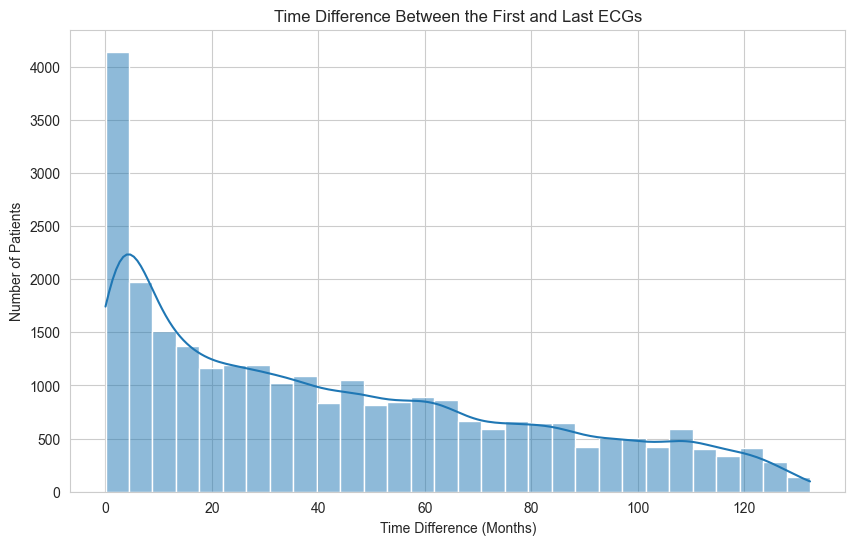

In [63]:
# Lets plot the distribution of the time difference between the first and last ECGs

# Only keep one register per admission
heart_failure_admissions_plot = \
heart_failure_admissions.drop_duplicates(subset=['subject_id', 'hadm_id'])


plt.figure(figsize=(10, 6))
sns.histplot(heart_failure_admissions_plot['time_difference'], bins=30, kde=True)
plt.title('Time Difference Between the First and Last ECGs')                                        # Set the title and labels
plt.xlabel('Time Difference (Months)')
plt.ylabel('Number of Patients')
plt.show()

In [ ]:
# How many patients have a time difference thats longer than 1 year?

heart_failure_admissions_long = \
heart_failure_admissions[heart_failure_admissions['time_difference'] > 12]                          # Filter patients with a time difference longer than 1 year
number_of_patients = heart_failure_admissions_long['subject_id'].nunique()                          # Count the number of unique patients
print(f'There are {number_of_patients} patients with a time difference between the first and last \
ECGs longer than 1 year.')

There are 6446 patients with a time difference between the first and last ECGs longer than 1 year.


Similar to the previous plot, the distribution of time differences between the first and last ECGs is right-skewed. Most patients have a time difference of less than 10 months, yet there are thousands of patients with differences exceeding 12 months. This indicates a substantial dataset available for analyzing the dynamic changes in the heart over time.

In [ ]:
# lets see how many unique patients we have left

'''
These patients have the following characteristics:
- They have more than one admission distributed over time
- They have at least one ECG during their hospitalization
- They have a heart failure diagnosis during each of their hospitalizations
'''

unique_patients = heart_failure_admissions['subject_id'].nunique()
print(f'There are {unique_patients} unique patients in the dataset with more than one admission, \
that have at least one ECG during their hospitalization and a heart failure diagnosis during each \
hospitalization.')


There are 10158 unique patients in the dataset with more than one admission, that have at least one ECG during their hospitalization and a heart failure diagnosis during each hospitalization.


# Conclusions and plan <a name='conclusions'></a>

- The MIMIC database contains a significant number of sequential ECGs recorded at various times of an individuals life.
- There are 6,400 patients with ECGs showing a time gap of more than one year between recordings.
- Aging profiles could be analyzed for patients, especially those diagnosed with heart failure. While this analysis won't establish causation between the chronic disease and aging, it can provide insights into how heart failure impacts biological age, as estimated using deep learning techniques.

Possible Plan Modification:

- We could analyze the heart profile changes over a one-year period for patients diagnosed with heart failure and compare these changes to a three-year mortality rate. Although we cannot establish causality due to the lack of information on other exposures between hospitalizations, this approach could offer insights into how heart aging progresses in this population. Additionally, it might reveal whether a greater difference in aging profiles is associated with mortality among hospitalized patients.

# References <a name='references'></a>
1. Johnson, Alistair, et al. "MIMIC-IV: A freely accessible electronic health record dataset." Schnpj (2021): 36596836. PubMed MIMIC-IV v2.2. PhysioNet
1. Johnson, A., Bulgarelli, L., Pollard, T., Horng, S., Celi, L. A., & Mark, R. (2023). MIMIC-IV (version 2.2). PhysioNet. https://doi.org/10.13026/6mm1-ek67.
1. Gow, B., Pollard, T., Nathanson, L. A., Johnson, A., Moody, B., Fernandes, C., Greenbaum, N., Waks, J. W., Eslami, P., Carbonati, T., Chaudhari, A., Herbst, E., Moukheiber, D., Berkowitz, S., Mark, R., & Horng, S. (2023). MIMIC-IV-ECG: Diagnostic Electrocardiogram Matched Subset (version 1.0). PhysioNet. https://doi.org/10.13026/4nqg-sb35.
1. Fan J, Li X, Yu X, Liu Z, Jiang Y, Fang Y, et al. Global Burden, Risk Factor Analysis, and Prediction Study of Ischemic Stroke, 1990–2030. Neurology [Internet]. 2023 Jul 11 [cited 2024 Jun 30];101(2). Available from: https://www.neurology.org/doi/10.1212/WNL.0000000000207387
1. Yang X, Gong Y, Waheed N, March K, Bian J, Hogan WR, et al. Identifying Cancer Patients at Risk for Heart Failure Using Machine Learning Methods. AMIA Annu Symp Proc. 2019;2019:933-41.